In [1]:
%matplotlib notebook
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'

## Construct a high resolution synthetic skyline spectra 

read in line data, build Gaussian profiles for each lines, add them up together. The wavelength is very refined here, which will be downgrad to DEIMOS resolution later 

In [2]:
# col2 = lambda, Central wavelength in Angstroem, in air 
# col3 = FWHM, Width of fitted gaussian in Angstroem
# col4 = Flux, Central flux in 10^-16^erg/s/cm2/{AA}
tb4 = Table.read('table4_yzedited.dat', format='ascii') # Sky emission lines from 3140 to  3760 {AA}
tb5 = Table.read('table5_yzedited.dat', format='ascii') # Sky emission lines from 3740 to  4850 {AA}
tb6 = Table.read('table6_yzedited.dat', format='ascii') # Sky emission lines from 4850 to  5770 {AA}
tb7 = Table.read('table7_yzedited.dat', format='ascii') # Sky emission lines from 5830 to  6700 {AA}
tb8 = Table.read('table8_yzedited.dat', format='ascii') # Sky emission lines from 6700 to  8540 {AA}
tb9 = Table.read('table9_yzedited.dat', format='ascii') # Sky emission lines from 8600 to 10430 {AA}

In [3]:
from astropy.modeling.models import Gaussian1D

In [4]:
# R = 45000
# dw = 3000/R = 0.07

wmin = 4000
wmax = 7500
dw = 0.05 # A let's do 0.05
wave_arr = np.mgrid[wmin:wmax:dw]

max_lambda = tb4['FWHM(A)'].min()-1 

final_spec = np.zeros(wave_arr.size)

for tb in [tb4, tb5, tb6, tb7, tb8, tb9]:     
    
    lambda_vac = tb['lambda_vac(A)']
    fwhm = tb['FWHM(A)']
    flux = tb['Flux(10^-16^erg/s/cm2/{AA})']
    
    # for lines that have already been used in the previous spectra, 
    # let's skip those 
    ind = lambda_vac>max_lambda
    lambda_vac = lambda_vac[ind]
    fwhm = fwhm[ind]
    flux = flux[ind]
    
    x = np.reshape(wave_arr, (wave_arr.shape[0], 1))
    amplitude = np.reshape(flux, (1, flux.shape[0]))
    mean = np.reshape(lambda_vac, (1, lambda_vac.shape[0]))
    std = np.reshape(fwhm, (1, fwhm.shape[0]))/2.355
    
    line_func = Gaussian1D(amplitude=amplitude, mean=mean, stddev=std)
    flux_arr = line_func(x)
    
    final_spec += np.sum(flux_arr, axis=1)
    max_lambda = lambda_vac.max()
    # break

Save this high resolution synthetic skyline spec

In [5]:
newtb = Table([wave_arr, final_spec], names=['lambda_vac(A)', 'Flux(10^-16^erg/s/cm2/{AA})'])
newtb.write('Hanuschik03_synthetic_skyline_spectrum_dw0.05A.dat', format='csv', overwrite=True)

## Read in synthetic spectra, figure out where the local maxium are at DEIMOS resolution 

In [2]:
skyspec = Table.read('Hanuschik03_synthetic_skyline_spectrum_dw0.05A.dat', format='ascii')

In [3]:
sky_flux = skyspec['Flux(10^-16^erg/s/cm2/{AA})']
sky_wave = skyspec['lambda_vac(A)']

dw = np.mean(sky_wave[1:]-sky_wave[:-1])
print(dw)

0.0500000000001819


Smooth the spectra to DEIMOS resolution 

In [4]:
1.92/4861 * 3e5

118.49413700884591

In [5]:
from scipy.ndimage import gaussian_filter

# 6 is in pixels, about what is measured in skylines from skycorr, 0.32A is the dispersion 
deimos_fwhm = 6*0.32 
sigma_nlambda = deimos_fwhm/2.355 # AA 
sigma_npix = sigma_nlambda/dw
print(sigma_nlambda, sigma_npix)
sky_flux_deimos = gaussian_filter(sky_flux, sigma_npix)

0.8152866242038216 16.305732484017113


In [6]:
#lines = np.asarray([5578, 5891.5, 5897.5, 5934.5, 5955.0, 6237.4, 
#                    6259.8, 6289.0, 6301, 6308.4, 6331.4, 
#         6365.4, 6500, 6534.6, 6836., 6865.4, 6914.4, 
#         6924.9, 6941.3, 6950.8, 6980.2])

lines = np.asarray([5578, 5891.5, 5897.5, 
                    6259.8, 6289.0, 6301, 6308.4, 6331.4, 
                    6365.4, 6500, 6534.6, 6914.4, 
                    6924.9, 6941.3, 6950.8, 6980.2])

acc_lines = np.zeros(len(lines))

dw = 1
for i in range(len(lines)): 
    ind = np.all([sky_wave>=lines[i]-dw, sky_wave<=lines[i]+dw], axis=0)
    sub_wave = sky_wave[ind]
    sub_flux_deimos = sky_flux_deimos[ind]
    
    acc_lines[i] = sub_wave[np.argmax(sub_flux_deimos)]

<IPython.core.display.Javascript object>


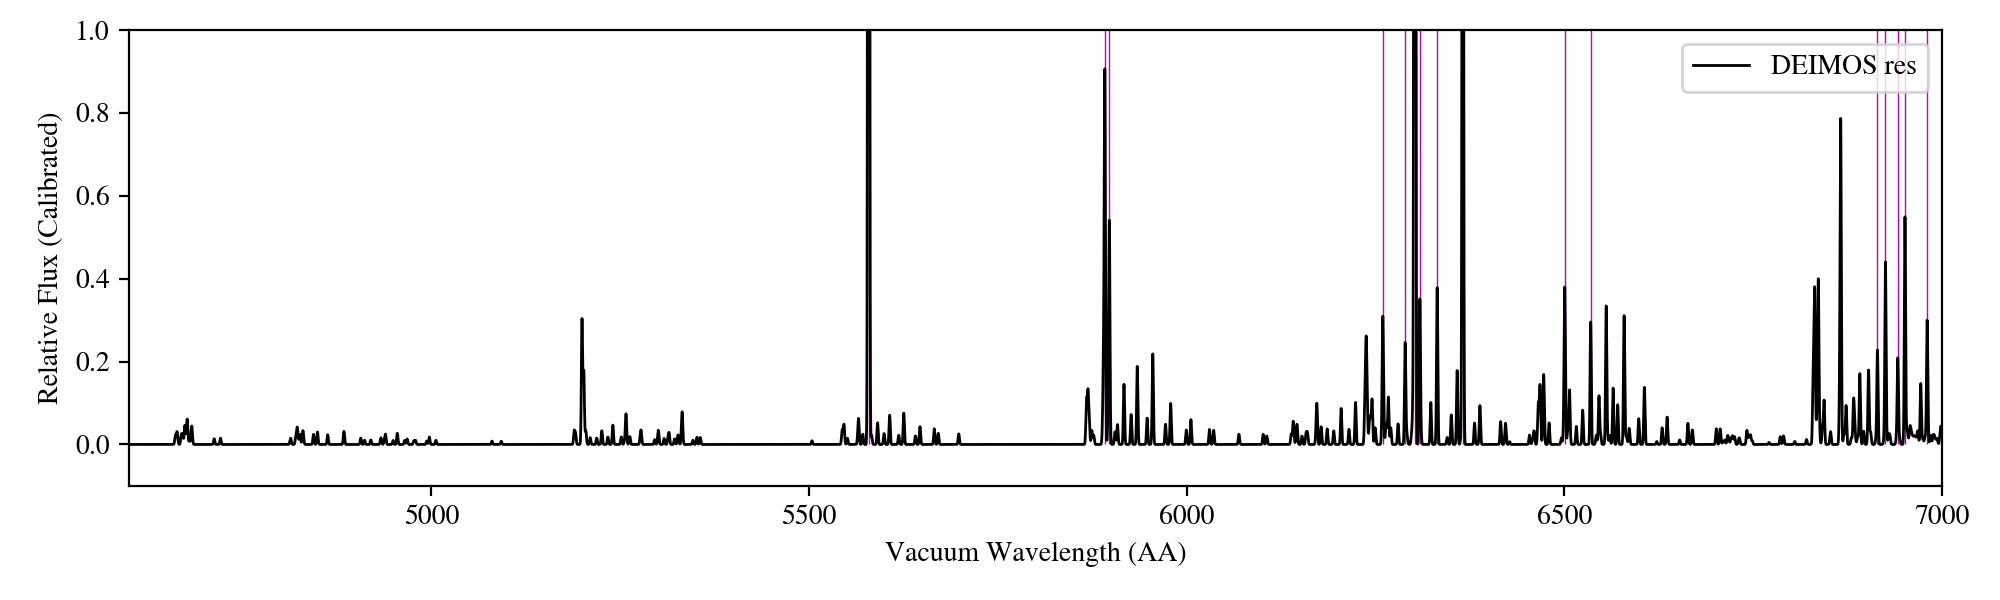

(-0.1, 1)

In [16]:
plt.figure(figsize=(10, 3))
# plt.plot(sky_wave, sky_flux, color='k', lw=0.5, label='Orignal sky spec')
plt.plot(sky_wave, sky_flux_deimos, color='k', lw=1, label='DEIMOS res')

for i in range(len(acc_lines)): 
    # print(i)
    plt.vlines(acc_lines[i], 0, 150, color='m', lw=0.5)
plt.xlim(4600, 7000)
plt.xlabel('Vacuum Wavelength (AA)')
plt.ylabel('Relative Flux (Calibrated)')
# plt.title('Synthetic Skyline Spectrum (pixsize=0.32 A, sigma=%.1fA), Hanuschik+2003'%(sigma_nlambda))
plt.tight_layout()
plt.legend()
plt.ylim(-0.1, 1)
# plt.savefig('synthetic_skyline_sig%0.1f.pdf'%(sigma_nlambda))
# plt.ylim(-2, 2)
# plt.savefig('synthetic_skyline.pdf')

In [8]:
from astropy.table import Table
from astropy.io import ascii

In [9]:
new_tb = Table([acc_lines], names=['skyline_wavevac(A)'])

In [10]:
new_tb.write('typical_skylinelist_DEIMOS_res.txt', format='csv')

#### resample to a grid with pixel size of 0.32 A/pix 

In [39]:
from scipy.interpolate import interp1d
new_func = interp1d(sky_wave, sky_flux_deimos)
sky_wave_deimos = np.mgrid[4000:7500:0.32]
sky_flux_deimos = new_func(sky_wave_deimos)

In [40]:
deimos_tb = Table([sky_wave_deimos, sky_flux_deimos], names=['lambda_vac(A)', 'Flux(10^-16^erg/s/cm2/{AA})'])
deimos_tb.write('Hanuschik03_synthetic_skyline_spectrum_DEIMOS-Res.dat', format='csv', overwrite=True)

<IPython.core.display.Javascript object>


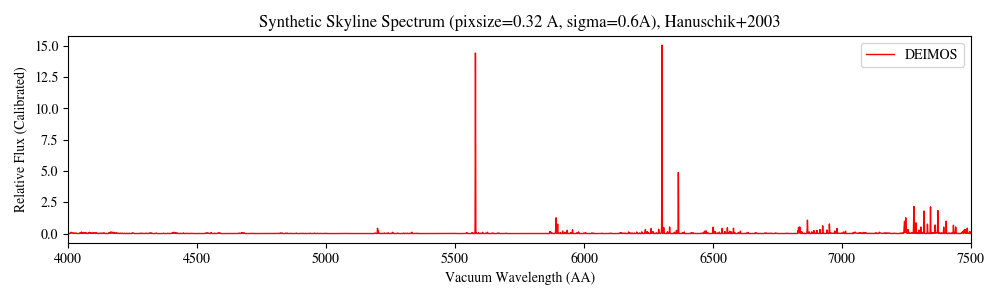

In [16]:
plt.figure(figsize=(10, 3))
#plt.plot(aa['lambda_vac(A)'], aa['Flux(10^-16^erg/s/cm2/{AA})'])
# plt.plot(sky_wave, sky_flux, color='k', lw=0.5, label='Orignal sky spec')
plt.plot(sky_wave_deimos, sky_flux_deimos, lw=1, color='r', label='DEIMOS')
plt.xlim(4000, 7500)
plt.xlabel('Vacuum Wavelength (AA)')
plt.ylabel('Relative Flux (Calibrated)')
plt.title('Synthetic Skyline Spectrum (pixsize=0.32 A, sigma=%.1fA), Hanuschik+2003'%(sigma_nlambda))
plt.tight_layout()
plt.legend()
plt.savefig('synthetic_skyline_sig%0.1f.pdf'%(sigma_nlambda))
# plt.ylim(-2, 2)
# plt.savefig('synthetic_skyline.pdf')

Provide a new sky line list at DEIMOS resolution, with a finer grid, here we just want to know where the local peak eamissions are 

In [ ]:
sky_wave

### Build a air2vac function from Edlen66 since this is what Hanuschik+2003 used for the conversion <br>

<font color='red'>Only need to run once. 09/14/2021. YZ. </font>

In [2]:
def air2vac_Edlen66(lambda_air, wmin=3000, wmax=12000, dw=0.0001): 
    
    #let's make a func from vac to air based on equation 1 from Edlen66 and Hanuschik03
    wave_vac_arr = np.mgrid[wmin:wmax:dw] # in unit of Ang
    sig = 1/(wave_vac_arr*u.AA.to(u.um)) # sigma is 1/lambda where lambda is in um 
    n = 1 + (1e-8)*(8342.13+ 2406030/(130-sig**2) + 15997/(38.9-sig**2))
    wave_air_arr = wave_vac_arr/n
    
    from scipy.interpolate import interp1d
    func_air2vac = interp1d(wave_air_arr, wave_vac_arr)
    
    # now get the vac wavelength we want 
    lambda_vac = func_air2vac(np.asarray(lambda_air))
    return np.around(lambda_vac, decimals=3)

<font color='red'>Double checked with pypeit formula. Very small difference (less than 0.0005)</font>

(array([142., 192., 151., 168., 171., 165., 166., 163., 188., 134.]),
 array([-6.07433050e-04, -5.05388743e-04, -4.03344436e-04, -3.01300129e-04,
        -1.99255822e-04, -9.72115154e-05,  4.83279164e-06,  1.06877099e-04,
         2.08921406e-04,  3.10965713e-04,  4.13010020e-04]),
 <BarContainer object of 10 artists>)

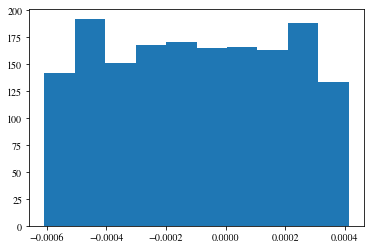

In [3]:
from pypeit.core.wave import airtovac

waveair = np.mgrid[3800:12000:5]

wavevac_E66 = air2vac_Edlen66(waveair)
wavevac_pypeit = airtovac(waveair*u.AA)

offset = wavevac_E66 - wavevac_pypeit.value
plt.hist(offset)

### ok, all tested. Now let's convert the air to vac in their tables 

In [4]:
# col2 = lambda, Central wavelength in Angstroem, in air 
# col3 = FWHM, Width of fitted gaussian in Angstroem
# col4 = Flux, Central flux in 10^-16^erg/s/cm2/{AA}
tb4 = Table.read('table4.dat', format='ascii') # Sky emission lines from 3140 to  3760 {AA}
tb5 = Table.read('table5.dat', format='ascii') # Sky emission lines from 3740 to  4850 {AA}
tb6 = Table.read('table6.dat', format='ascii') # Sky emission lines from 4850 to  5770 {AA}
tb7 = Table.read('table7.dat', format='ascii') # Sky emission lines from 5830 to  6700 {AA}
tb8 = Table.read('table8.dat', format='ascii') # Sky emission lines from 6700 to  8540 {AA}
tb9 = Table.read('table9.dat', format='ascii') # Sky emission lines from 8600 to 10430 {AA}

In [5]:
for tb, tb_tag in zip([tb4, tb5, tb6, tb7, tb8, tb9], '456789'): 
    wave_air = tb['col2']
    fwhm = tb['col3']
    flux = tb['col4']
    
    wave_vac = air2vac_Edlen66(wave_air)
    
    # compare the offset 
    wave_vac_pypeit = airtovac(wave_air*u.AA)
    offset = wave_vac - wave_vac_pypeit.value
    plt.figure()
    plt.hist(offset)
    plt.title('table%s: wave vac value offset between Edlen66 and pypeit'%(tb_tag))
    plt.xlabel('AA')
    plt.savefig('table%s_yzedited.pdf'%(tb_tag))
    plt.close()

    # and now write a new table
    newname = 'table%s_yzedited.dat'%(tb_tag)
    f = open(newname, 'w')
    f.write('lambda_air(A)  lambda_vac(A)  FWHM(A)  Flux(10^-16^erg/s/cm2/{AA})\n')
    for i in range(len(wave_vac)): 
        f.write('%11.4f  %11.4f  %6.4f  %8.4f\n'%(wave_air[i], wave_vac[i], fwhm[i], flux[i]))
    f.close()
    # break

put a master skyline table together for all tables 4-9. 

In [6]:
# col2 = lambda, Central wavelength in Angstroem, in air 
# col3 = FWHM, Width of fitted gaussian in Angstroem
# col4 = Flux, Central flux in 10^-16^erg/s/cm2/{AA}
tb4 = Table.read('table4_yzedited.dat', format='ascii') # Sky emission lines from 3140 to  3760 {AA}
tb5 = Table.read('table5_yzedited.dat', format='ascii') # Sky emission lines from 3740 to  4850 {AA}
tb6 = Table.read('table6_yzedited.dat', format='ascii') # Sky emission lines from 4850 to  5770 {AA}
tb7 = Table.read('table7_yzedited.dat', format='ascii') # Sky emission lines from 5830 to  6700 {AA}
tb8 = Table.read('table8_yzedited.dat', format='ascii') # Sky emission lines from 6700 to  8540 {AA}
tb9 = Table.read('table9_yzedited.dat', format='ascii') # Sky emission lines from 8600 to 10430 {AA}

In [8]:
from astropy.table import vstack 

final_tb = tb4 
max_lambda = tb4['FWHM(A)'].max()
for tb in [tb5, tb6, tb7, tb8, tb9]:     
    
    # for lines already in previous table, skip those
    lambda_vac = tb['lambda_vac(A)']
    ind = lambda_vac>max_lambda
    this_tb = tb[ind]
    
    final_tb = vstack([final_tb, this_tb])

In [10]:
final_tb.write('Hanuschik03_all_skylines_yz.txt', format='csv')

In [11]:
final_tb

lambda_air(A),lambda_vac(A),FWHM(A),Flux(10^-16^erg/s/cm2/{AA})
float64,float64,float64,float64
3142.6768,3143.587,0.073,1.5474
3143.3757,3144.286,0.0637,1.0259
3143.6824,3144.593,0.1236,1.0973
3144.0857,3144.996,0.0954,1.9536
3145.5142,3146.425,0.0835,2.2297
3145.9248,3146.836,0.0654,1.5056
3147.2148,3148.126,0.0414,0.8647
3147.7874,3148.699,0.0909,1.7371
3147.9854,3148.897,0.0659,0.9111
